# Notebook used  to experiment with different models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
from sklearn.metrics import  mean_pinball_loss

In [17]:
!python3 -m pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
df = pd.read_csv("../traces/traces_persona.csv",parse_dates=[0])[:].reset_index()
diff = [df["reconsile_dates"][i] - df["reconsile_dates"][i-1] for i in range(1,len(df["reconsile_dates"]))]
diff_df = pd.DataFrame({"diff": diff, "sec": [x.total_seconds() for x in diff]}) 

endtrain  =  int(len(diff_df) * 0.8)
startTestIndex = endtrain
endtestIndex =  len(diff_df)-1

train_data = diff_df["sec"][:endtrain]
test_data = diff_df["sec"][endtrain:]

In [34]:
df,diff_df


(                      reconsile_dates
 0    2023-01-17 13:45:57.861000+00:00
 1    2023-01-17 13:46:00.918000+00:00
 2    2023-01-17 13:46:05.918000+00:00
 3    2023-01-17 13:46:11.046000+00:00
 4    2023-01-17 13:46:16.173000+00:00
 ...                               ...
 996  2023-01-17 15:12:21.972000+00:00
 997  2023-01-17 15:12:27.178000+00:00
 998  2023-01-17 15:12:32.338000+00:00
 999  2023-01-17 15:12:37.529000+00:00
 1000 2023-01-17 15:12:42.682000+00:00
 
 [1001 rows x 1 columns],
                       diff    sec
 0   0 days 00:00:03.057000  3.057
 1          0 days 00:00:05  5.000
 2   0 days 00:00:05.128000  5.128
 3   0 days 00:00:05.127000  5.127
 4   0 days 00:00:05.144000  5.144
 ..                     ...    ...
 995 0 days 00:00:05.180000  5.180
 996 0 days 00:00:05.206000  5.206
 997 0 days 00:00:05.160000  5.160
 998 0 days 00:00:05.191000  5.191
 999 0 days 00:00:05.153000  5.153
 
 [1000 rows x 2 columns])

In [35]:
df.describe(),diff_df.describe()

/tmp/ipykernel_13633/1579199578.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(),diff_df.describe()


(                         reconsile_dates
 count                               1001
 unique                              1001
 top     2023-01-17 13:45:57.861000+00:00
 freq                                   1
 first   2023-01-17 13:45:57.861000+00:00
 last    2023-01-17 15:12:42.682000+00:00,
                             diff          sec
 count                       1000  1000.000000
 mean      0 days 00:00:05.204821     5.204821
 std    0 days 00:00:00.611235877     0.611236
 min       0 days 00:00:00.206000     0.206000
 25%       0 days 00:00:05.168750     5.168750
 50%       0 days 00:00:05.198000     5.198000
 75%       0 days 00:00:05.230000     5.230000
 max       0 days 00:00:21.442000    21.442000)

In [36]:
df_stationarityTest = adfuller(df['reconsile_dates'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  1.0


/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


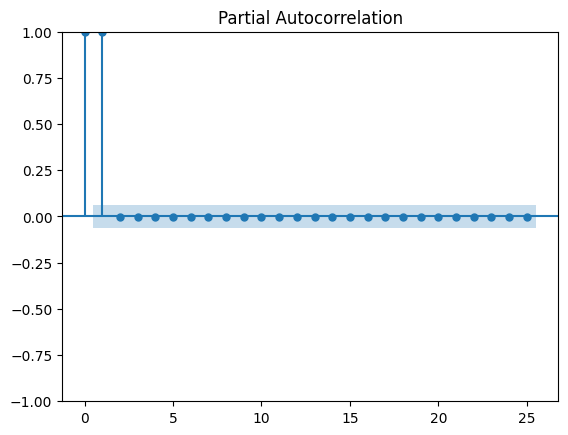

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['reconsile_dates'], lags=25)

# only use 2 long wide interval?

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe37d4b0190>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe37d4b06d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe37d4b3910>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe37d415420>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe37d4156c0>],
 'means': []}

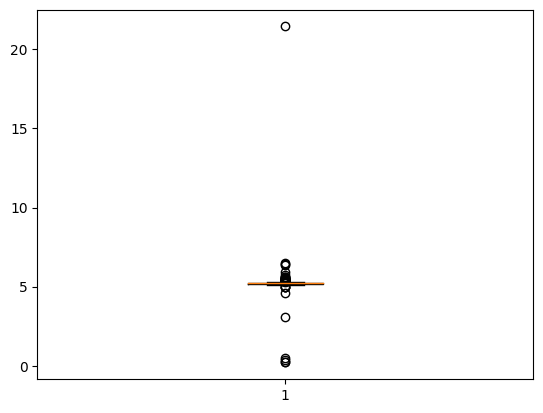

In [38]:
plt.boxplot([diff_df["sec"]])

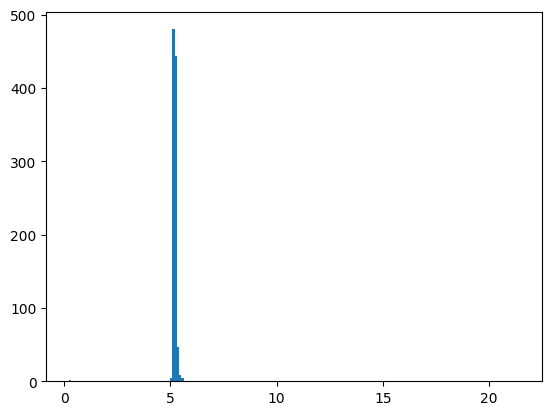

In [39]:
_ =  plt.hist(diff_df["sec"],bins=200)

# choosing loss function

In [9]:
# as defined in the scikit-learn  docs
# sklearn.metrics.mean_pinball_loss
def pinball_loss(y_true,y_pred, alpha=0.25):
    diff = y_true - y_pred
    sign = int(diff >= 0)
    loss = alpha * sign  * diff - (1 - alpha) * (1 - sign) * diff
    return loss

def total_perside_piball_loss(y_true_array,y_pred_array, alpha=0.25):
    assert len(y_pred_array) == len(y_true_array)
    underEstimate = []
    overEstimate = []
    totalEstimate = []
    for y_true,y_pred in zip(y_true_array,y_pred_array):

        diff = y_true - y_pred
        sign = int(diff >= 0)
        
        score = pinball_loss(y_true=y_true, y_pred=y_pred,alpha=alpha)
        
        if sign == 0:
            overEstimate.append(score)
        else:
            underEstimate.append(score)
        totalEstimate.append(score)
    
    underEstimate_score = np.mean(underEstimate)
    overEstimate_score = np.mean(overEstimate)
    ##print(totalEstimate)
    total_score = np.mean(totalEstimate)
    
    print(f"there are {len(underEstimate)} underEstimates with mean {underEstimate_score} ")
    print(f"there are {len(overEstimate)} overEstimates with mean {overEstimate_score}")
    print(f"total mean absolute pinball score {total_score}")
    return (underEstimate_score,overEstimate_score,total_score)

def plotDifferencepredictions(pred,testdata):
    #plt.rcParams["figure.figsize"] = (30, 10)

    
    pred = pd.DataFrame(pred)
    pred.index = test_data.index

    f, ax = plt.subplots() 
    f.set_figwidth(25)
    f.set_figheight(10)
    ax.plot(pred,'yo',label="prediction")
    ax.plot(testdata,'o', color='red',label="real")
    #plt.plot(pred,'yo',label="prediction")
    #plt.plot(testdata,'o', color='red',label="real")
    plt.legend(fontsize="xx-large")
    plt.show()





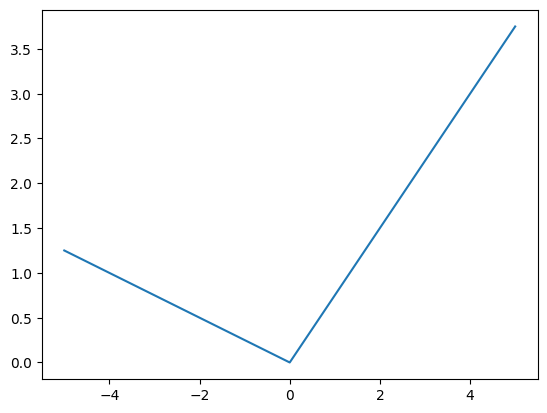

In [41]:
alpha = 0.25 
x = np.concatenate([np.arange(-5,0,0.1), np.arange(0,5.1,0.1)])
y = [pinball_loss(0,i,alpha) for  i in x]
plt.plot(x,y)


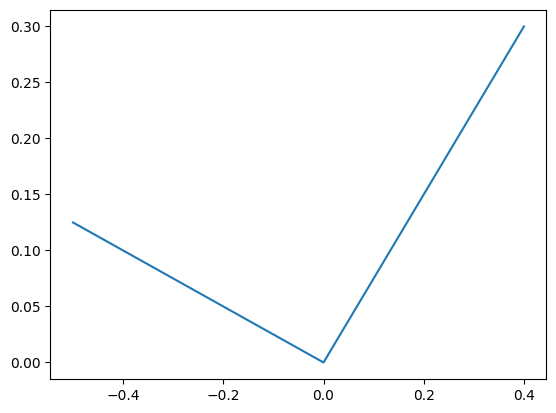

In [42]:
alpha = 0.25 
x = np.concatenate([np.arange(-0.5,0,0.1), np.arange(0,0.5,0.1)])
y = [pinball_loss(0,i,alpha) for  i in x]
#plt.xticks(np.arange(-1,1,0.25))

plt.plot(x,y)


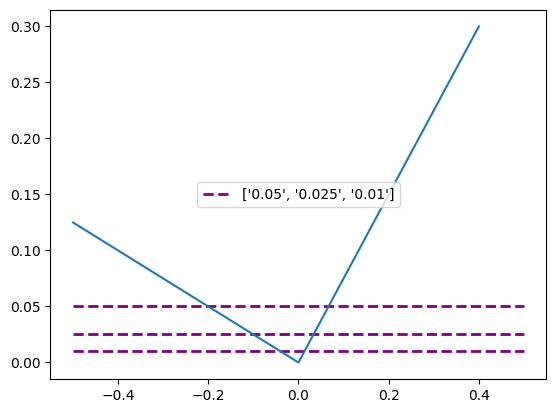

In [43]:
alpha = 0.25 
x = np.concatenate([np.arange(-0.5,0,0.1), np.arange(0,0.5,0.1)])
y = [pinball_loss(0,i,alpha) for  i in x]
plt.hlines(y=[0.05, 0.025, 0.01],xmin=-0.5, xmax=0.5, colors='purple', linestyles='--', lw=2,label=["0.05","0.025",'0.01'])
#plt.xticks(np.arange(-1,1,0.25))
plt.legend( loc="center", borderaxespad=0)
plt.plot(x,y)


## auto regression

In [44]:
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

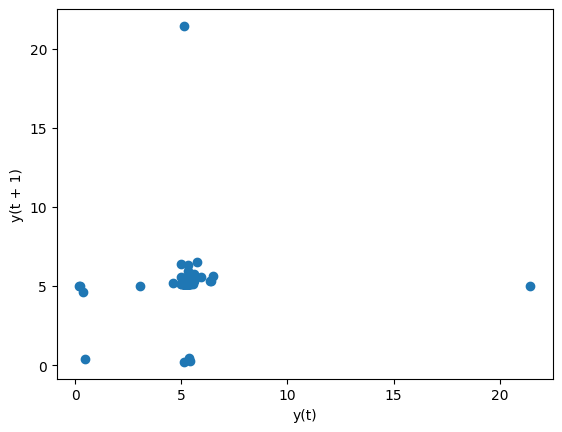

In [45]:
lag_plot(diff_df["sec"])

not really a lot of corrolation, no real line  visable

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

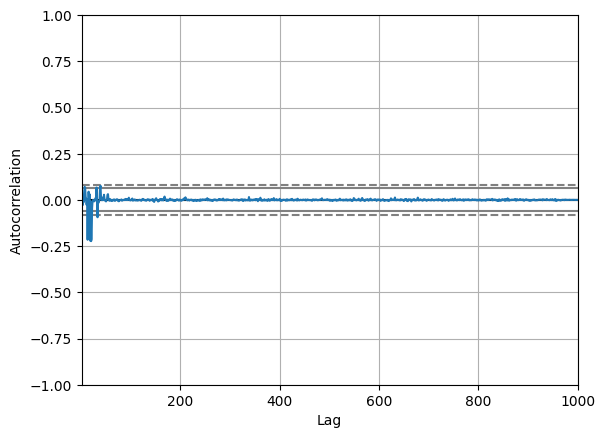

In [46]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(diff_df["sec"])

as expected, since the times are constant, no real big  swings, by adding more lag, we don't gain anything 

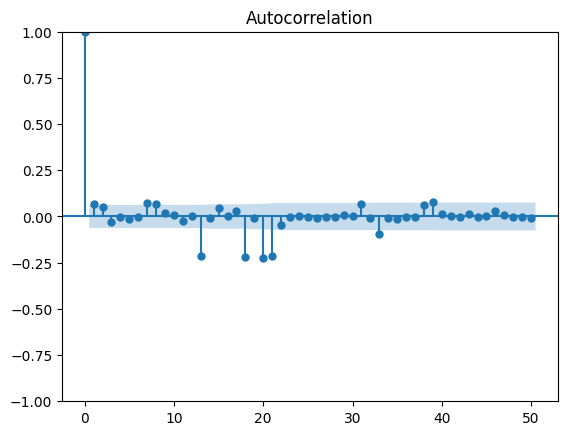

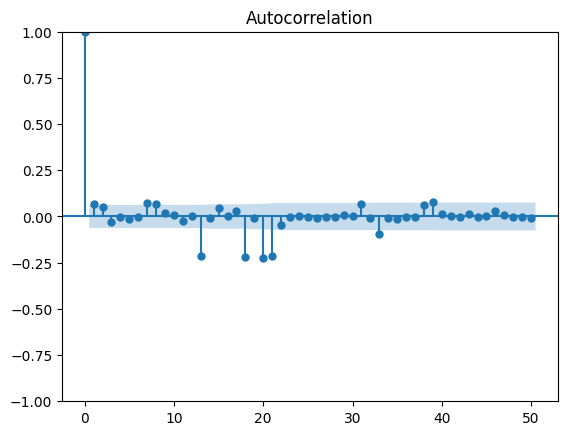

In [47]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diff_df["sec"], lags=50)

after 25 we see only small differences

In [48]:
model = AutoReg(train_data, lags=10).fit()
print(model.summary())
pred = model.predict(start=startTestIndex, end=endtestIndex, dynamic=False)

                            AutoReg Model Results                             
Dep. Variable:                    sec   No. Observations:                  800
Model:                    AutoReg(10)   Log Likelihood                -812.571
Method:               Conditional MLE   S.D. of innovations              0.677
Date:                Wed, 15 Mar 2023   AIC                           1649.141
Time:                        20:39:21   BIC                           1705.205
Sample:                            10   HQIC                          1670.691
                                  800                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2236      0.527      8.013      0.000       3.190       5.257
sec.L1         0.0605      0.036      1.701      0.089      -0.009       0.130
sec.L2         0.0527      0.036      1.478      0.1

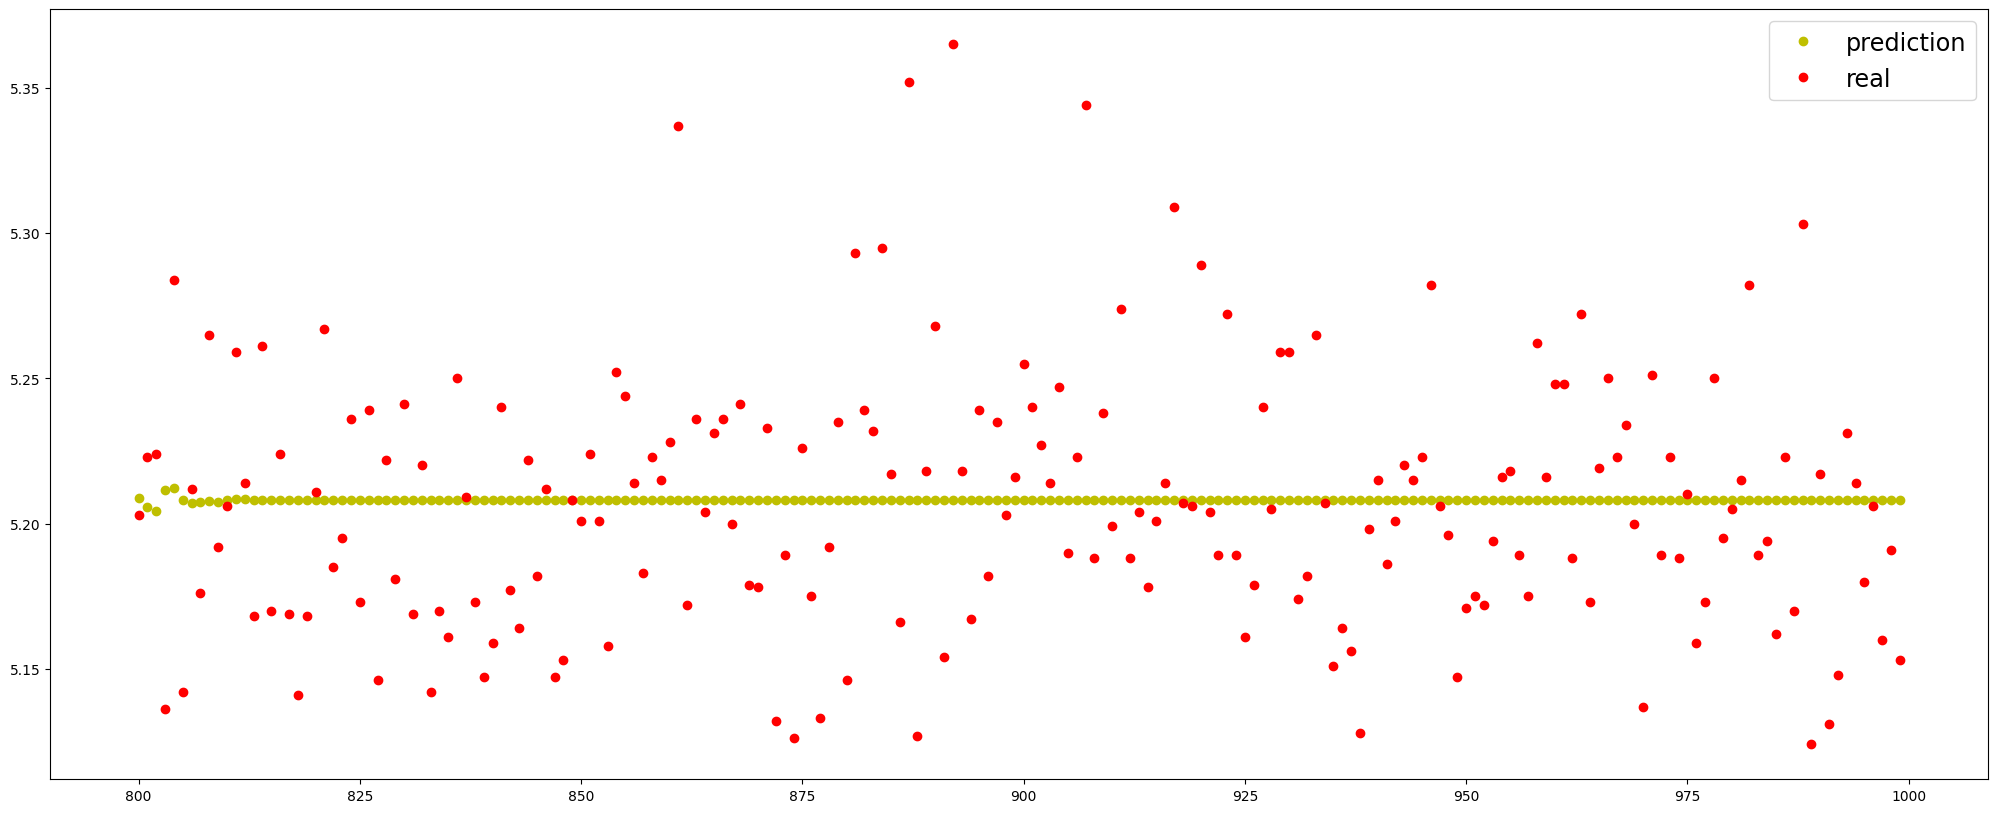

In [49]:
plotDifferencepredictions(pred,test_data)

In [50]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 93 underEstimates with mean 0.00886419801756572 
there are 107 overEstimates with mean 0.024683173504844783
total mean absolute pinball score 0.017327349903260018


(0.00886419801756572, 0.024683173504844783, 0.017327349903260018)

instead of predicting all test results at a time, do 1 by 1 and relearn like  our framework can do

In [51]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = AutoReg(diff_df["sec"][:i], lags=10).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])


In [52]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 92 underEstimates with mean 0.009244003971309079 
there are 108 overEstimates with mean 0.024898724841082527
total mean absolute pinball score 0.017697553240986735


(0.009244003971309079, 0.024898724841082527, 0.017697553240986735)

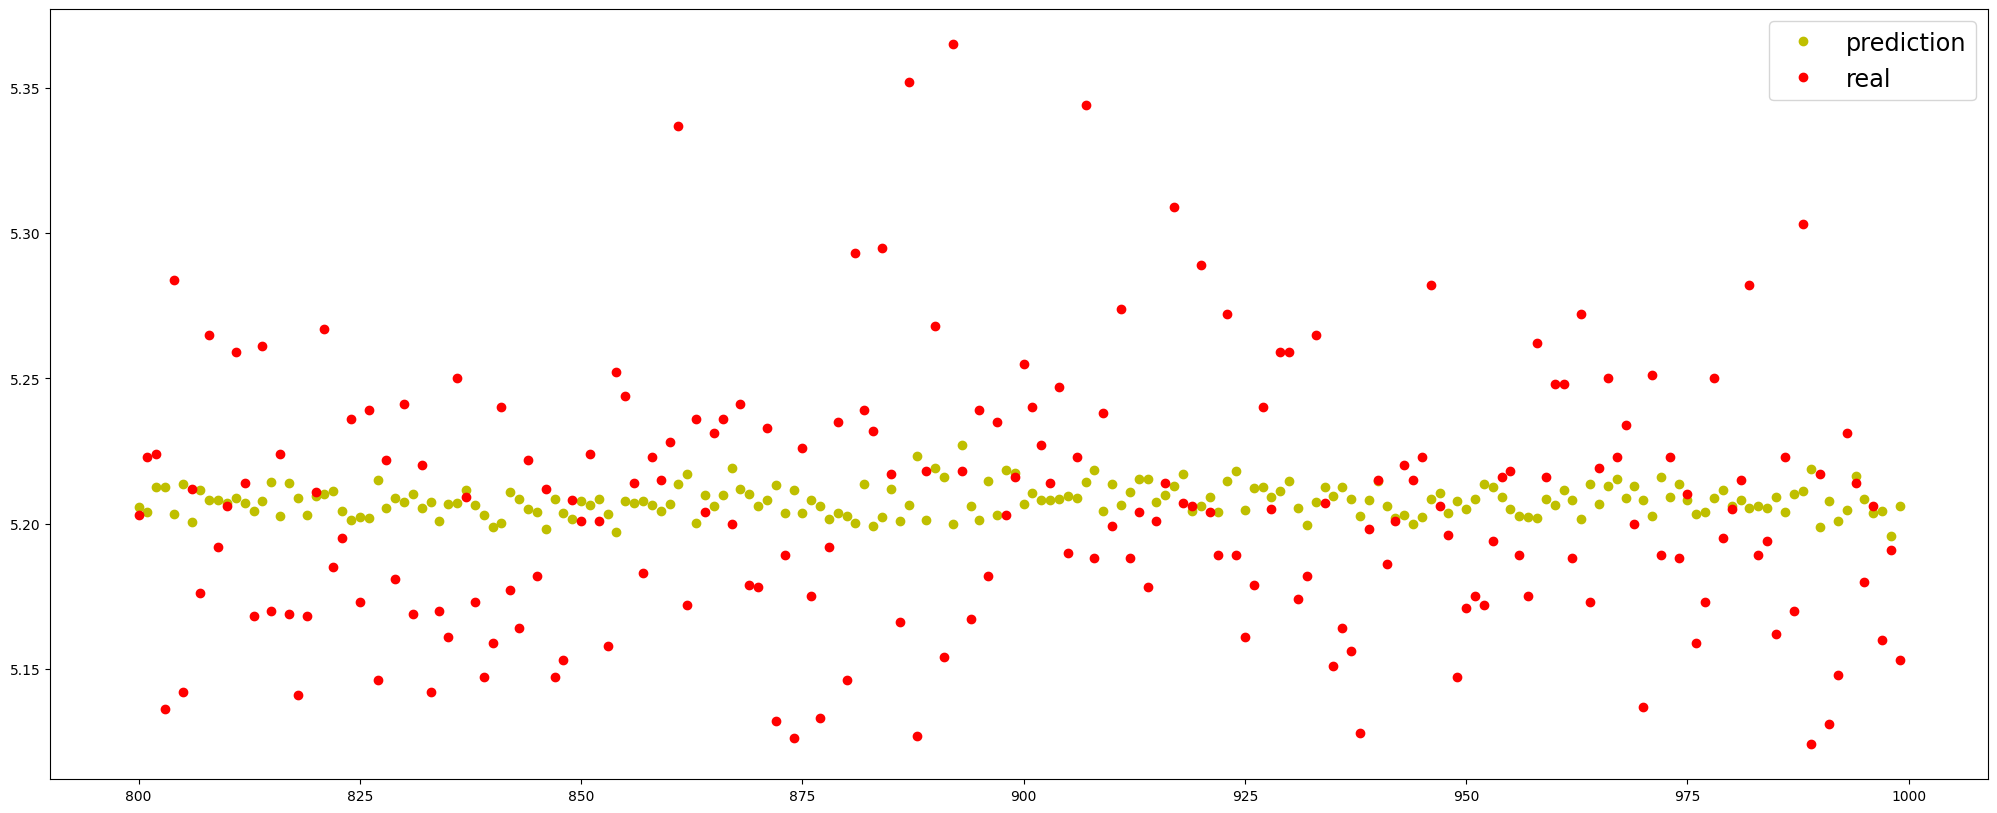

In [53]:
plotDifferencepredictions(pred,test_data)

as expected  we do not  see a lot of improvement

# arima

In [54]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [55]:
adf,pval,_,_,_,_ = adfuller(diff_df["sec"])
print(f"p value {pval} < 0.05 => stationairy")

p value 1.7417236011374657e-24 < 0.05 => stationairy


choose what arima model

In [56]:
model = pm.auto_arima(diff_df["sec"], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6152.731, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2472.050, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5069.922, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1853.852, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1856.332, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1853.352, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1854.101, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1855.204, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1854.695, Time=0.69 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1856.101, Time=0.87 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 4.175 seconds


In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -922.676
Date:                Wed, 15 Mar 2023   AIC                           1853.352
Time:                        20:39:28   BIC                           1872.983
Sample:                             0   HQIC                          1860.813
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6063      0.265     17.362      0.000       4.086       5.126
ar.L1          0.0643      0.013      4.988      0.000       0.039       0.090
ar.L2          0.0506      0.048      1.048      0.295      -0.044       0.145
sigma2         0.3706      0.002    232.902      0.000       0.368       0.374
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          11316047.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            16.98
Prob(H) (two-sided):                  0.00   Kurtosis:                       523.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
model = ARIMA(train_data, order=(2, 0, 0))

In [59]:
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    sec   No. Observations:                  800
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -826.978
Date:                Wed, 15 Mar 2023   AIC                           1661.956
Time:                        20:39:29   BIC                           1680.695
Sample:                             0   HQIC                          1669.155
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2039      0.042    124.055      0.000       5.122       5.286
ar.L1          0.0641      0.016      3.975      0.000       0.033       0.096
ar.L2          0.0501      0.059      0.843      0.399      -0.066       0.167
sigma2         0.4628      0.002    186.321      0.000       0.458       0.468
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           5808909.57
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            15.22
Prob(H) (two-sided):                  0.00   Kurtosis:                       419.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
pred = result.predict(start=startTestIndex, end=endtestIndex)

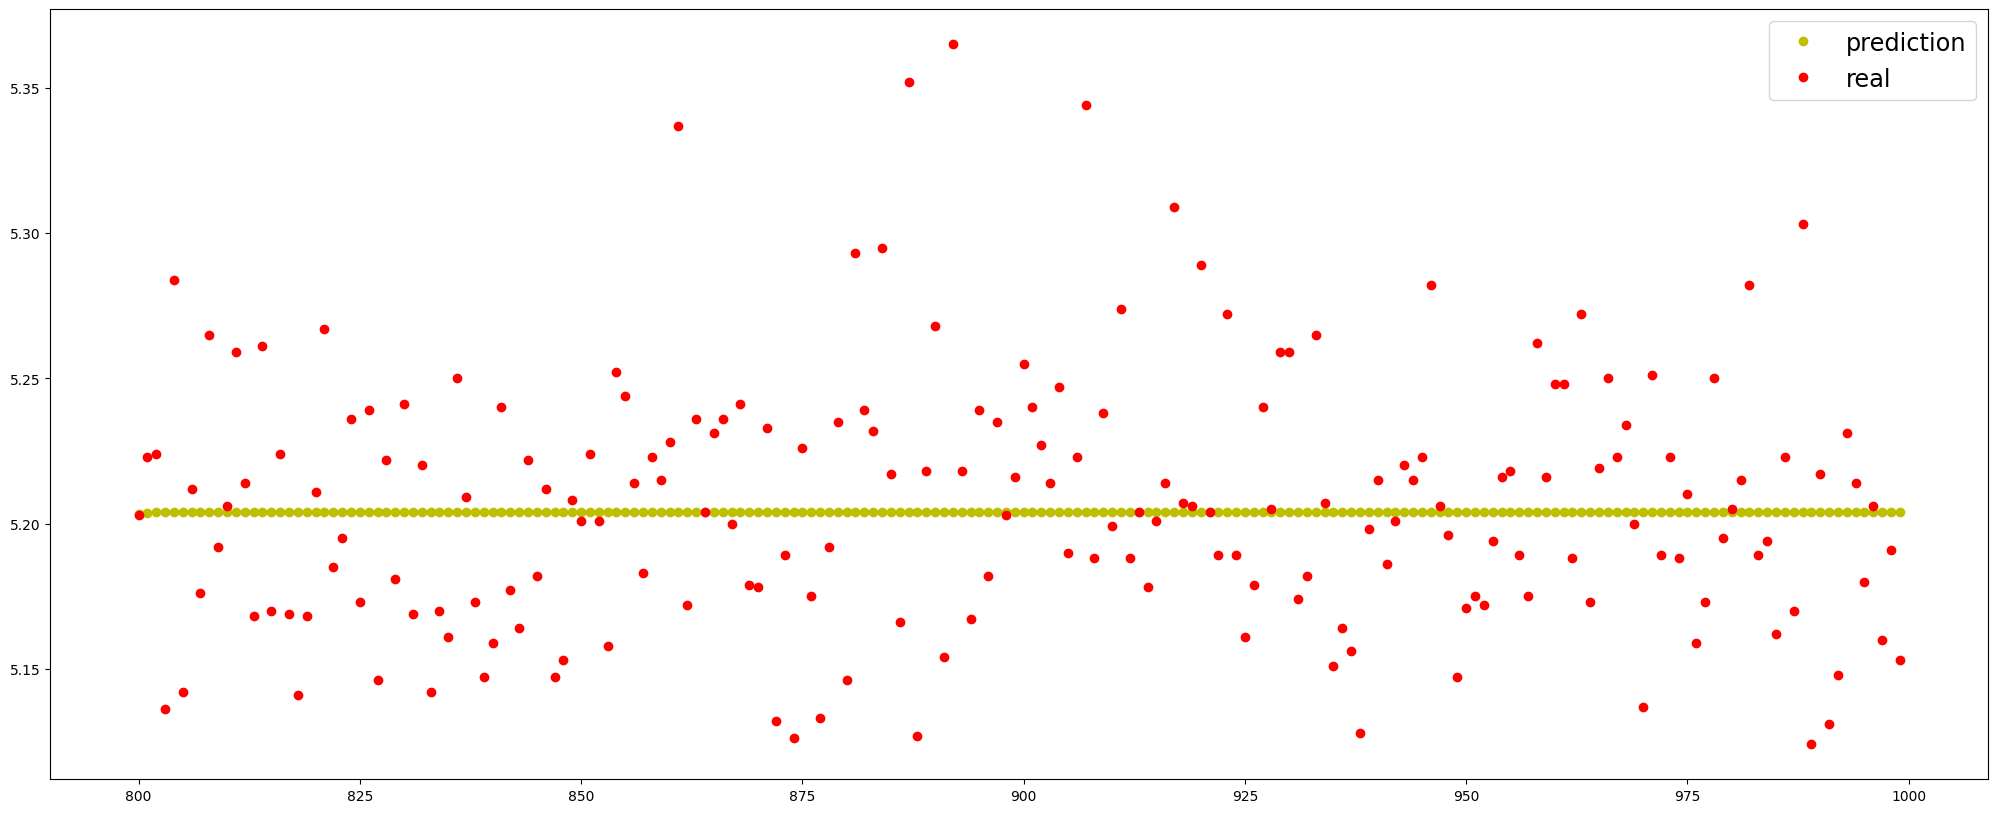

In [61]:
plotDifferencepredictions(pred,test_data)

In [62]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 105 underEstimates with mean 0.008824387377224399 
there are 95 overEstimates with mean 0.024399480096544468
total mean absolute pinball score 0.016222556418901433


(0.008824387377224399, 0.024399480096544468, 0.016222556418901433)

In [63]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = ARIMA(diff_df["sec"][:i], order=(2, 0, 0)).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])

In [64]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 99 underEstimates with mean 0.00932542573735128 
there are 101 overEstimates with mean 0.023602233898079396
total mean absolute pinball score 0.01653521385851898


(0.00932542573735128, 0.023602233898079396, 0.01653521385851898)

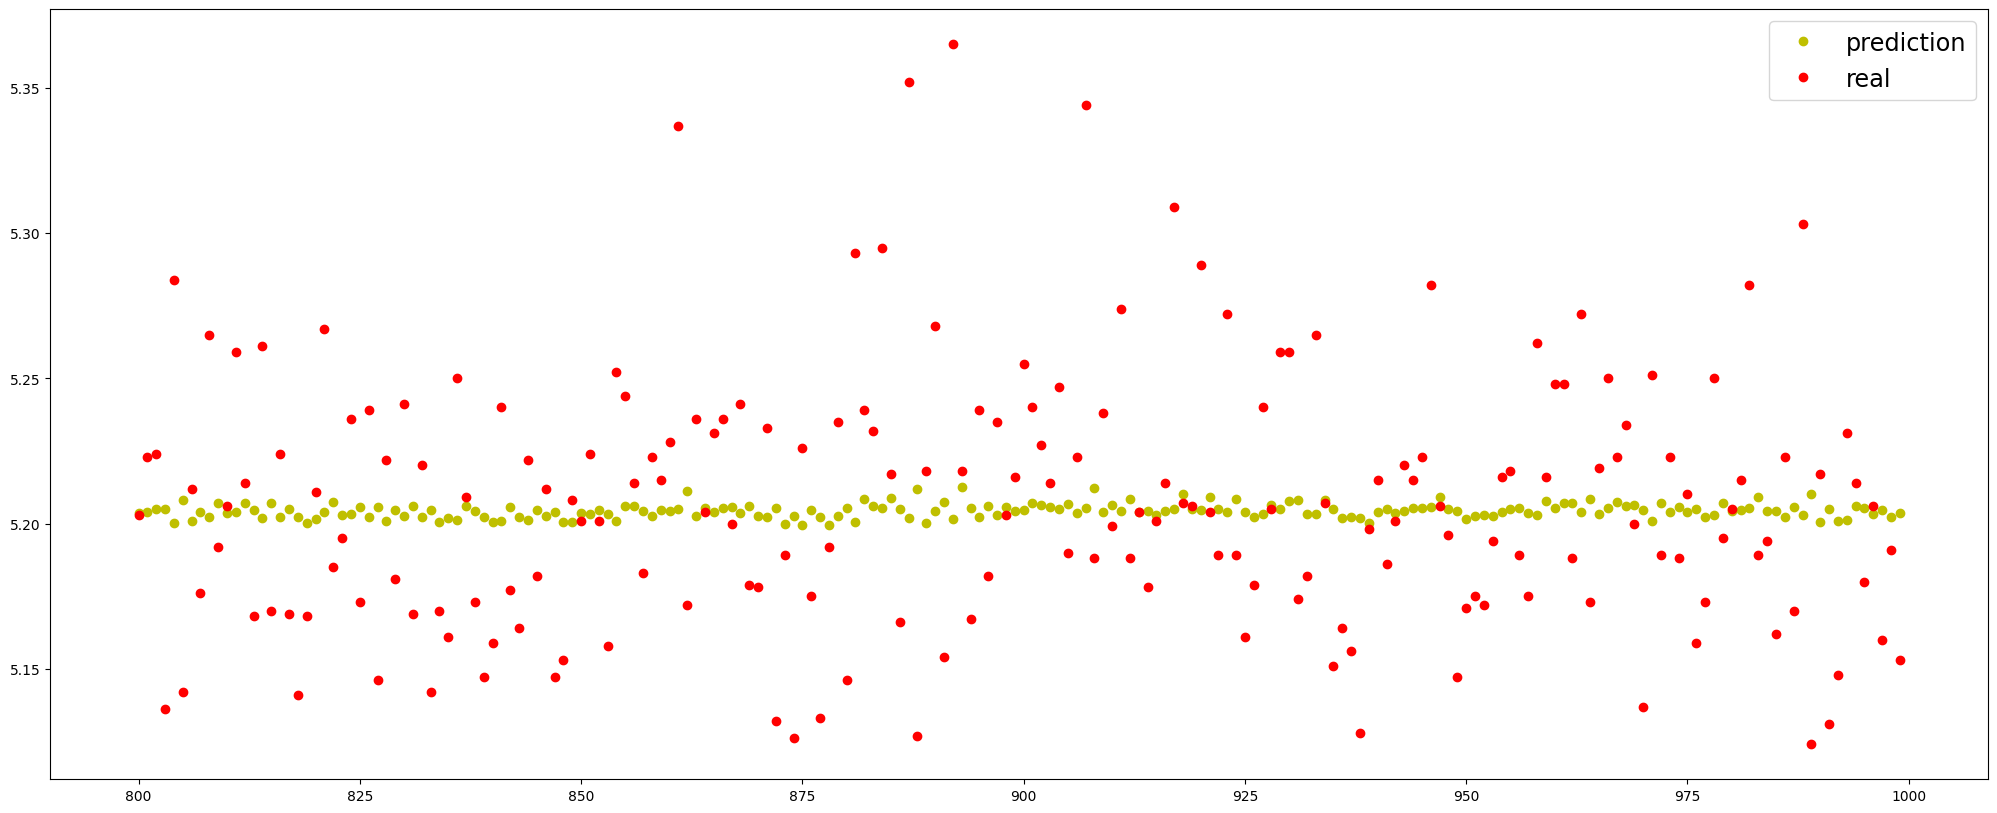

In [65]:
plotDifferencepredictions(pred,test_data)

# sarima

our data is  not really  seasonal so  skip this

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [67]:
model = SARIMAX(train_data, order=(2, 0, 0))

In [68]:
result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20922D+00    |proj g|=  4.57167D-03

At iterate    5    f=  1.20922D+00    |proj g|=  7.02219D-04

At iterate   10    f=  1.20921D+00    |proj g|=  6.23692D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   6.237D-06   1.209D+00
  F =   1.2092059222922071     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    sec   No. Observations:                  800
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -967.365
Date:                Wed, 15 Mar 2023   AIC                           1940.729
Time:                        20:39:50   BIC                           1954.783
Sample:                             0   HQIC                          1946.128
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5034      0.004    128.429      0.000       0.496       0.511
ar.L2          0.4882      0.005    105.484      0.000       0.479       0.497
sigma2         0.6541      0.003    210.780      0.000       0.648       0.660
===================================================================================
Ljung-Box (L1) (Q):                  13.49   Jarque-Bera (JB):           1804531.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             7.67
Prob(H) (two-sided):                  0.00   Kurtosis:                       235.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
pred = result.predict(start=startTestIndex, end=endtestIndex)

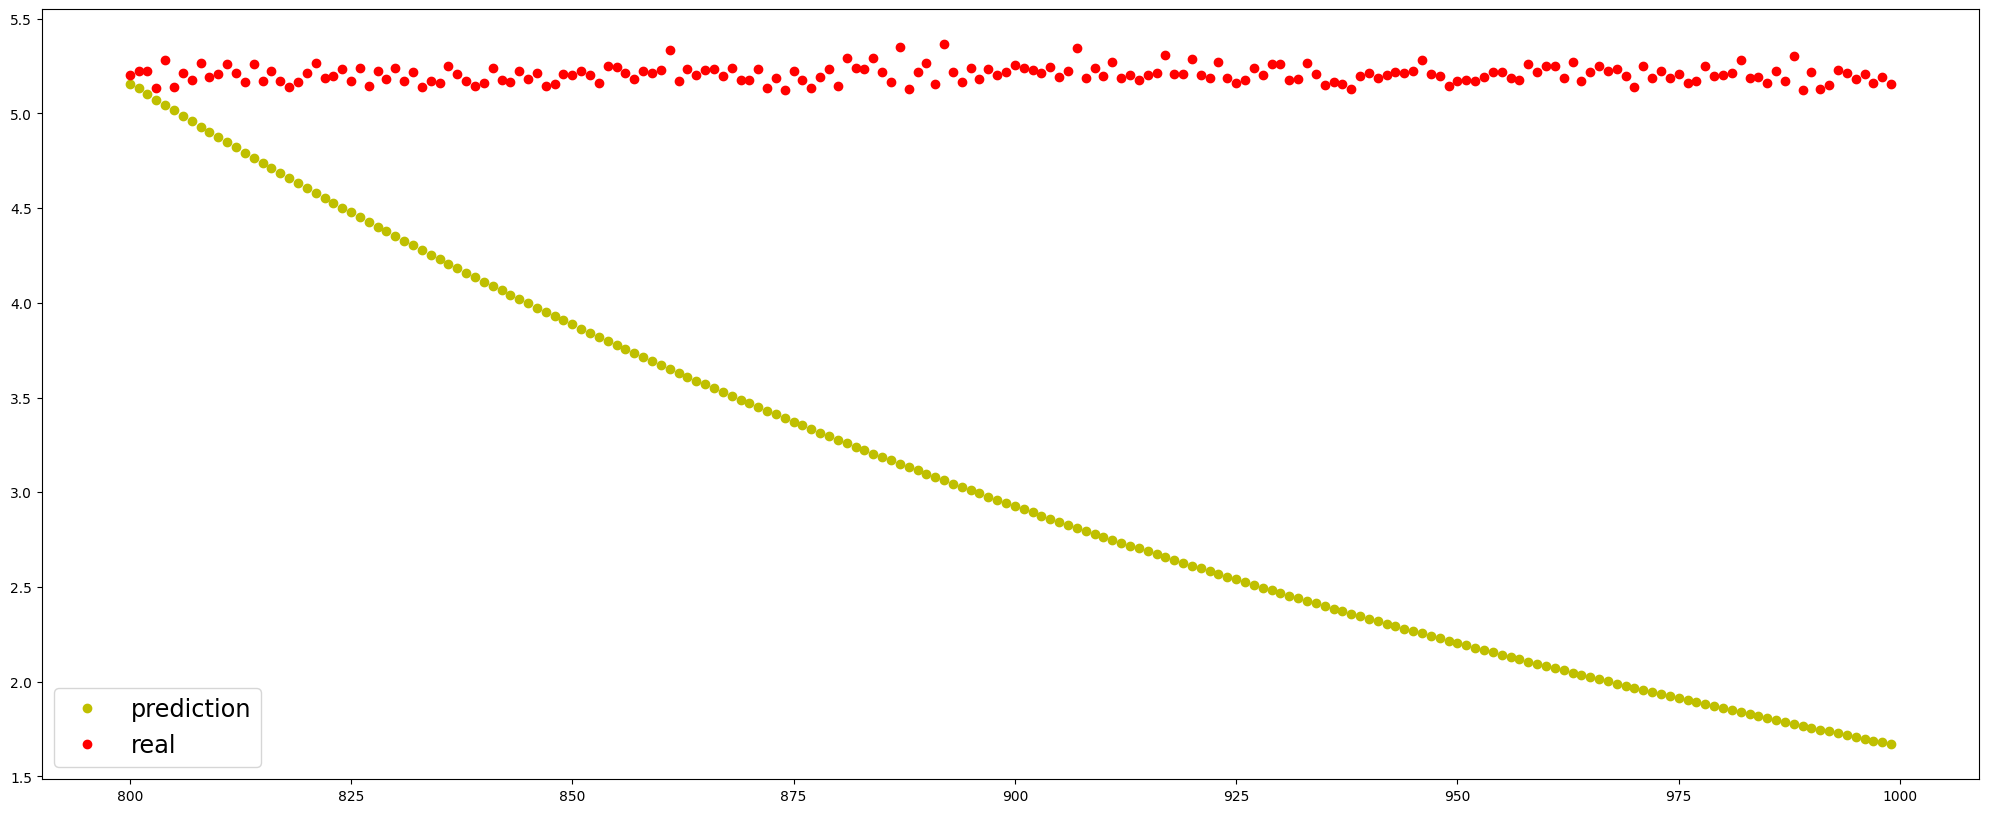

In [70]:
plotDifferencepredictions(pred,test_data)

In [71]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 200 underEstimates with mean 0.5281108210663504 
there are 0 overEstimates with mean nan
total mean absolute pinball score 0.5281108210663504


/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kevin/Documents/unief/ugent2022-2023/masterproef/wasm-operator/prediction/webserver/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.5281108210663504, nan, 0.5281108210663504)

predicting that far into the future is pritty bad

In [ ]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = SARIMAX(diff_df["sec"][:i], order=(2, 0, 0)).fit()
    predict = model.predict(start=i+1, end=(i+1), dynamic=False)
    pred.append(predict[i+1])


In [73]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 171 underEstimates with mean 0.01828417405667318 
there are 29 overEstimates with mean 0.01960165803133733
total mean absolute pinball score 0.01847520923299948


(0.01828417405667318, 0.01960165803133733, 0.01847520923299948)

model predicts pritty good, underestimates more, which is better for our framework

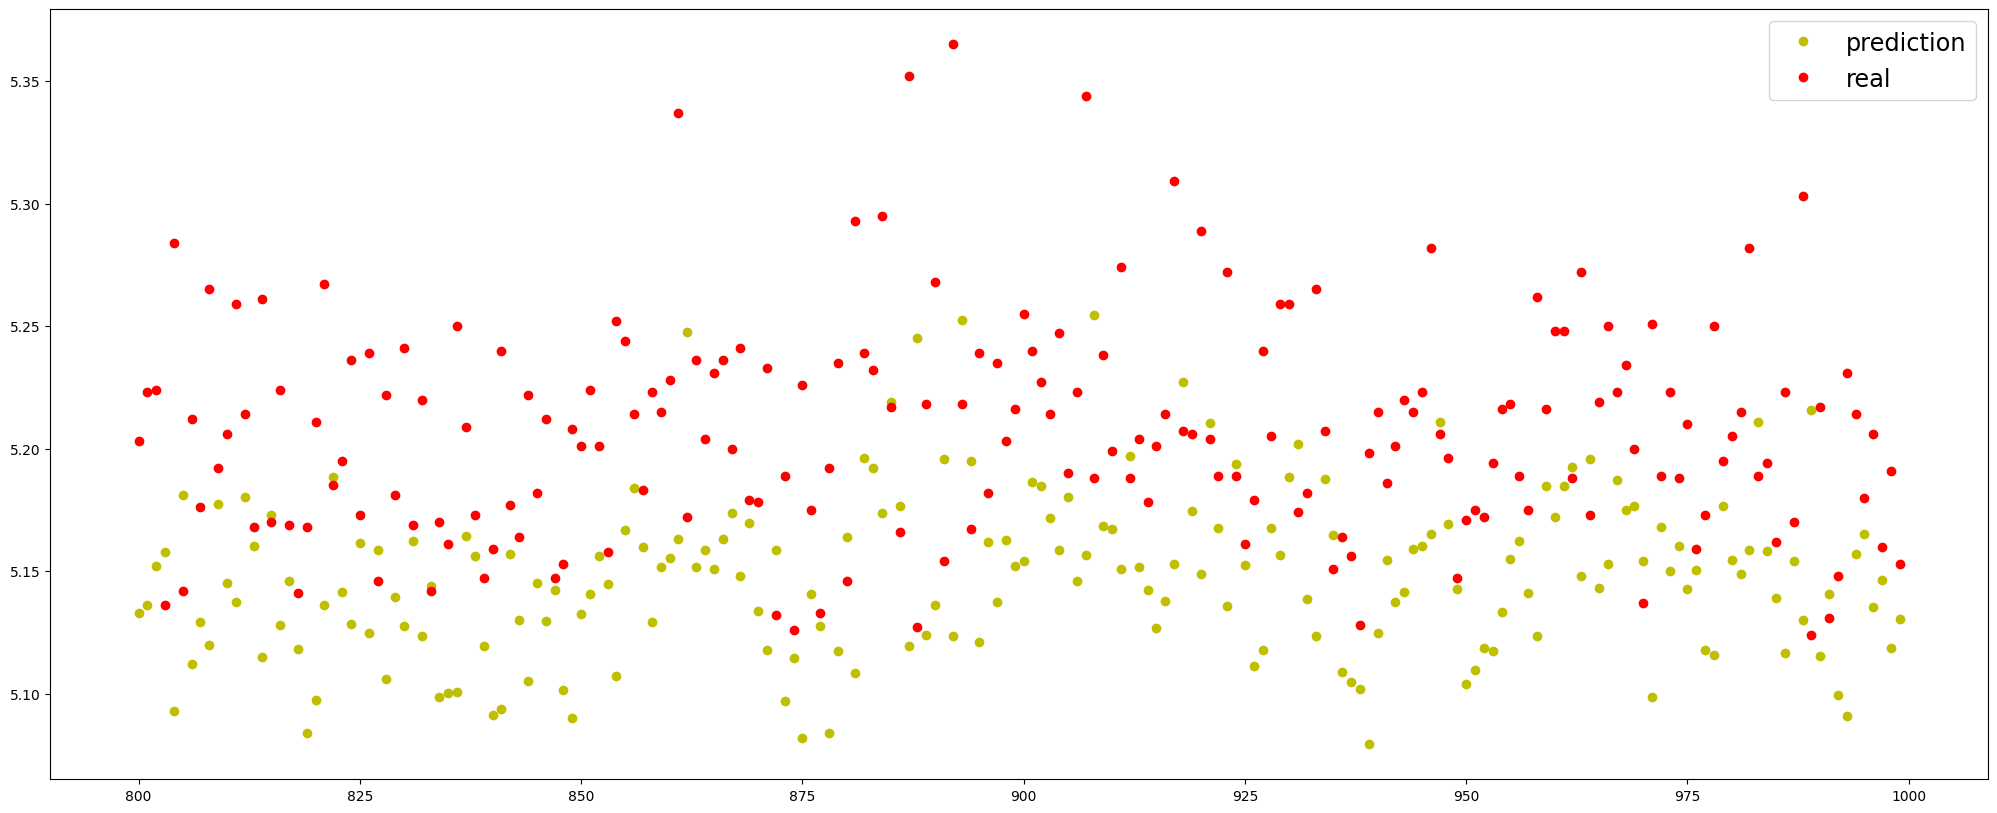

In [74]:
plotDifferencepredictions(pred,test_data)

# Exponential smoothing

## simple  smoothing

In [75]:
from statsmodels.tsa.api import  SimpleExpSmoothing

In [76]:
model = SimpleExpSmoothing(train_data, initialization_method="estimated")
result = model.fit()

In [77]:
pred =  result.predict(start=startTestIndex, end=endtestIndex)

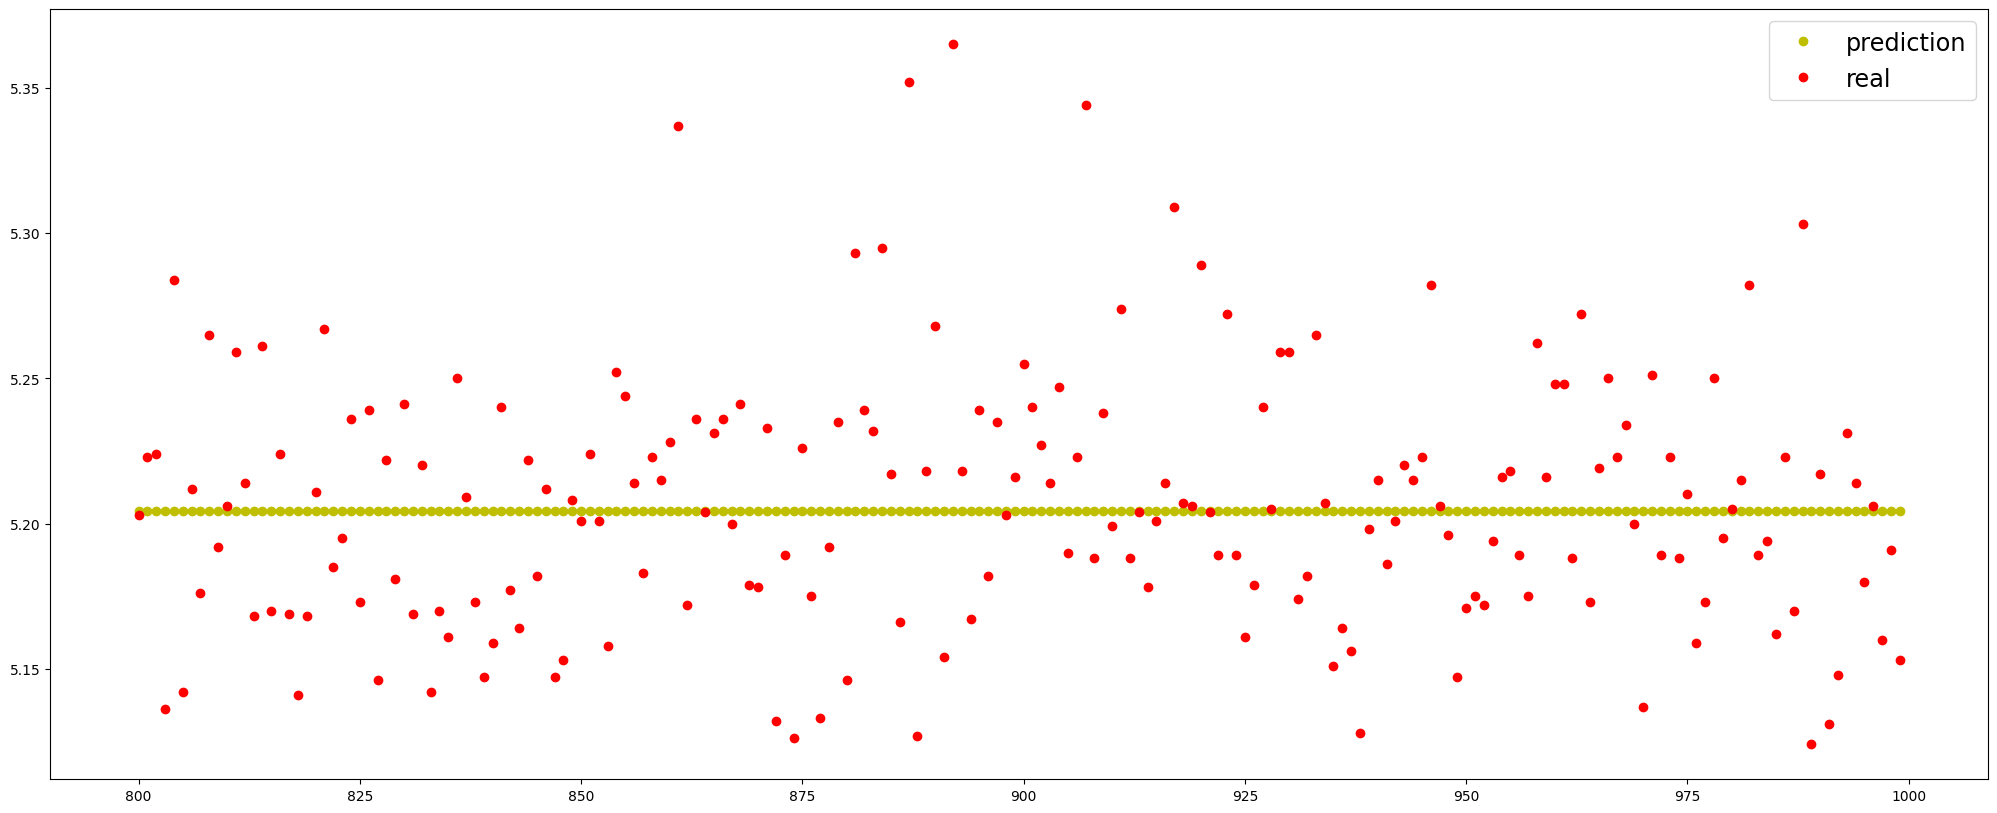

In [78]:
plotDifferencepredictions(pred,test_data)

In [79]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 102 underEstimates with mean 0.008976203648516283 
there are 98 overEstimates with mean 0.023972949678700898
total mean absolute pinball score 0.016324609203306743


(0.008976203648516283, 0.023972949678700898, 0.016324609203306743)

In [80]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = SimpleExpSmoothing(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [81]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 100 underEstimates with mean 0.00910203841044454 
there are 100 overEstimates with mean 0.023690504318524513
total mean absolute pinball score 0.01639627136448452


(0.00910203841044454, 0.023690504318524513, 0.01639627136448452)

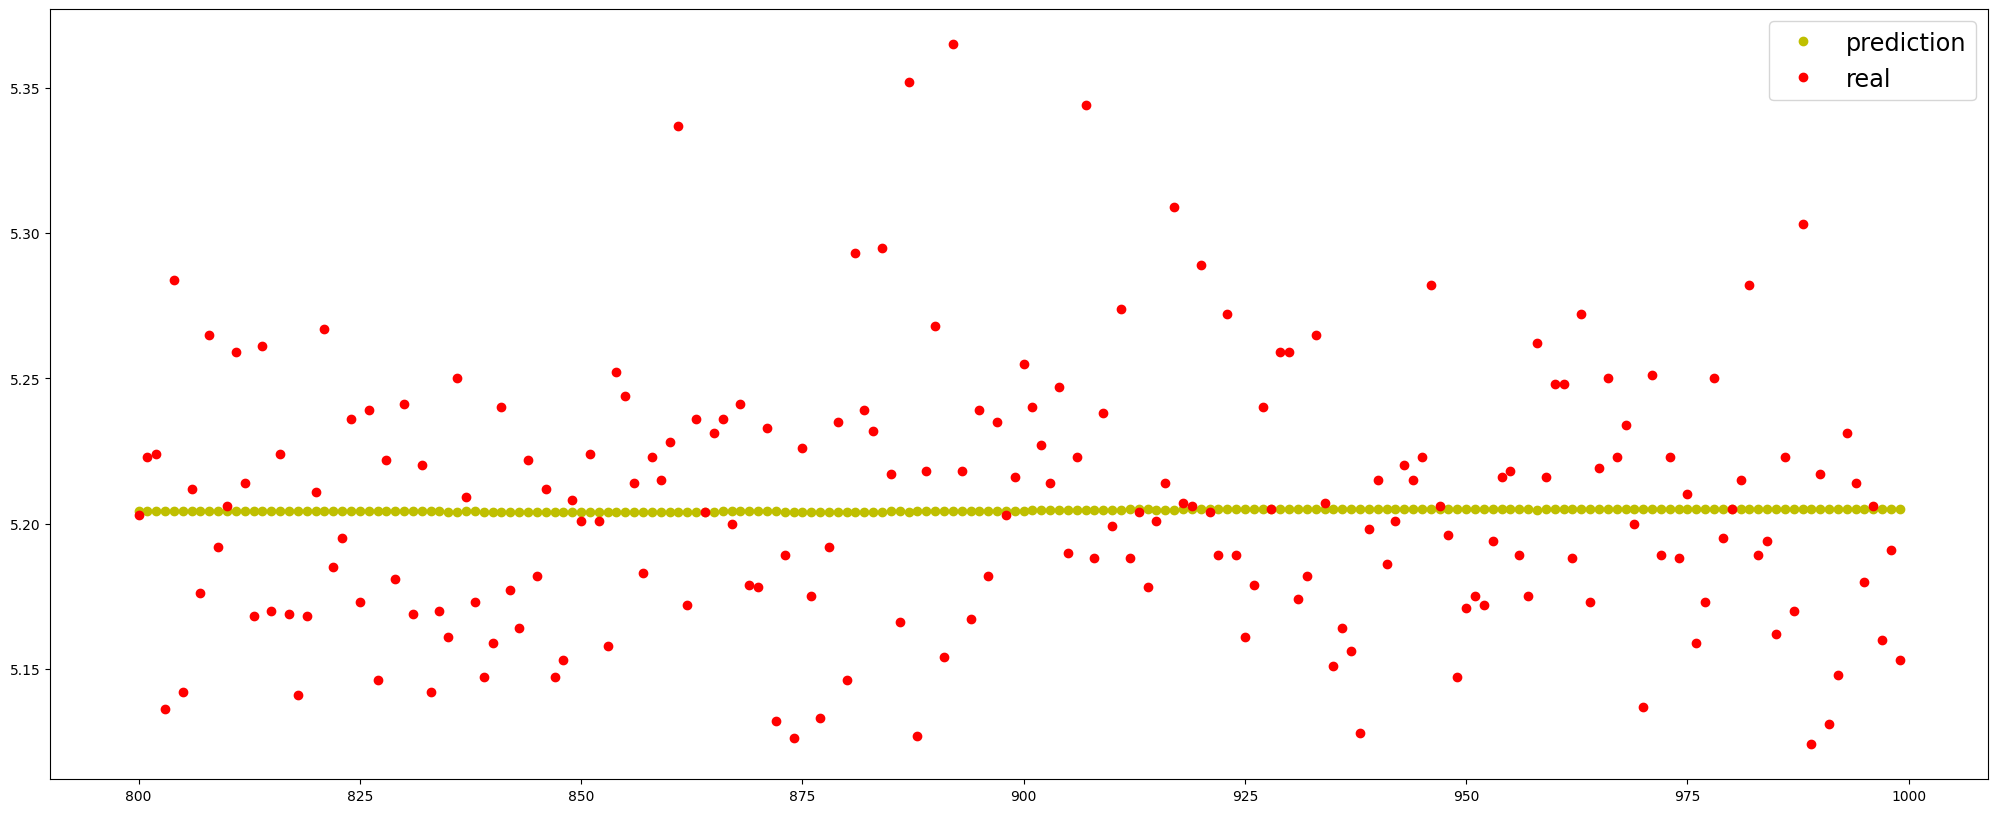

In [82]:
plotDifferencepredictions(pred,test_data)

##  Holt

In [83]:
from statsmodels.tsa.api import  Holt

In [84]:
model = Holt(train_data, initialization_method="estimated")
result = model.fit()

In [85]:
pred =  result.predict(start=startTestIndex, end=endtestIndex)

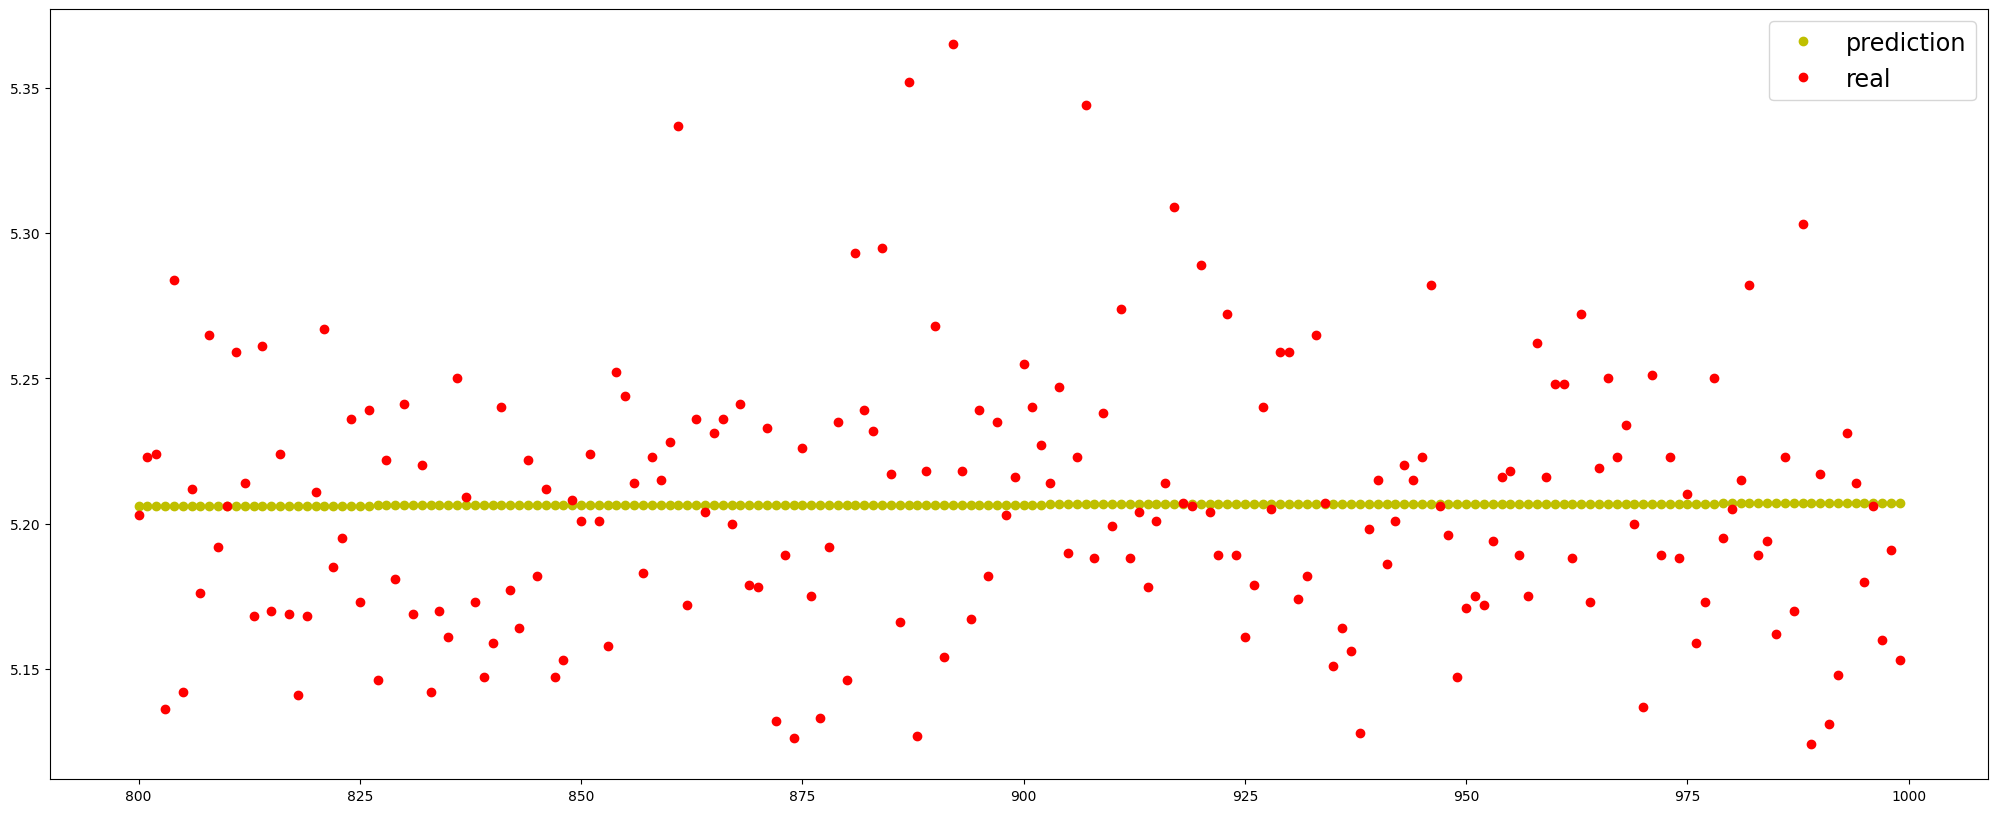

In [86]:
plotDifferencepredictions(pred,test_data)

In [87]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 96 underEstimates with mean 0.008962064828373932 
there are 104 overEstimates with mean 0.02421011925209374
total mean absolute pinball score 0.01689105312870823


(0.008962064828373932, 0.02421011925209374, 0.01689105312870823)

In [88]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = Holt(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [89]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 94 underEstimates with mean 0.009150895870901716 
there are 106 overEstimates with mean 0.024045705963195156
total mean absolute pinball score 0.017045145219817242


(0.009150895870901716, 0.024045705963195156, 0.017045145219817242)

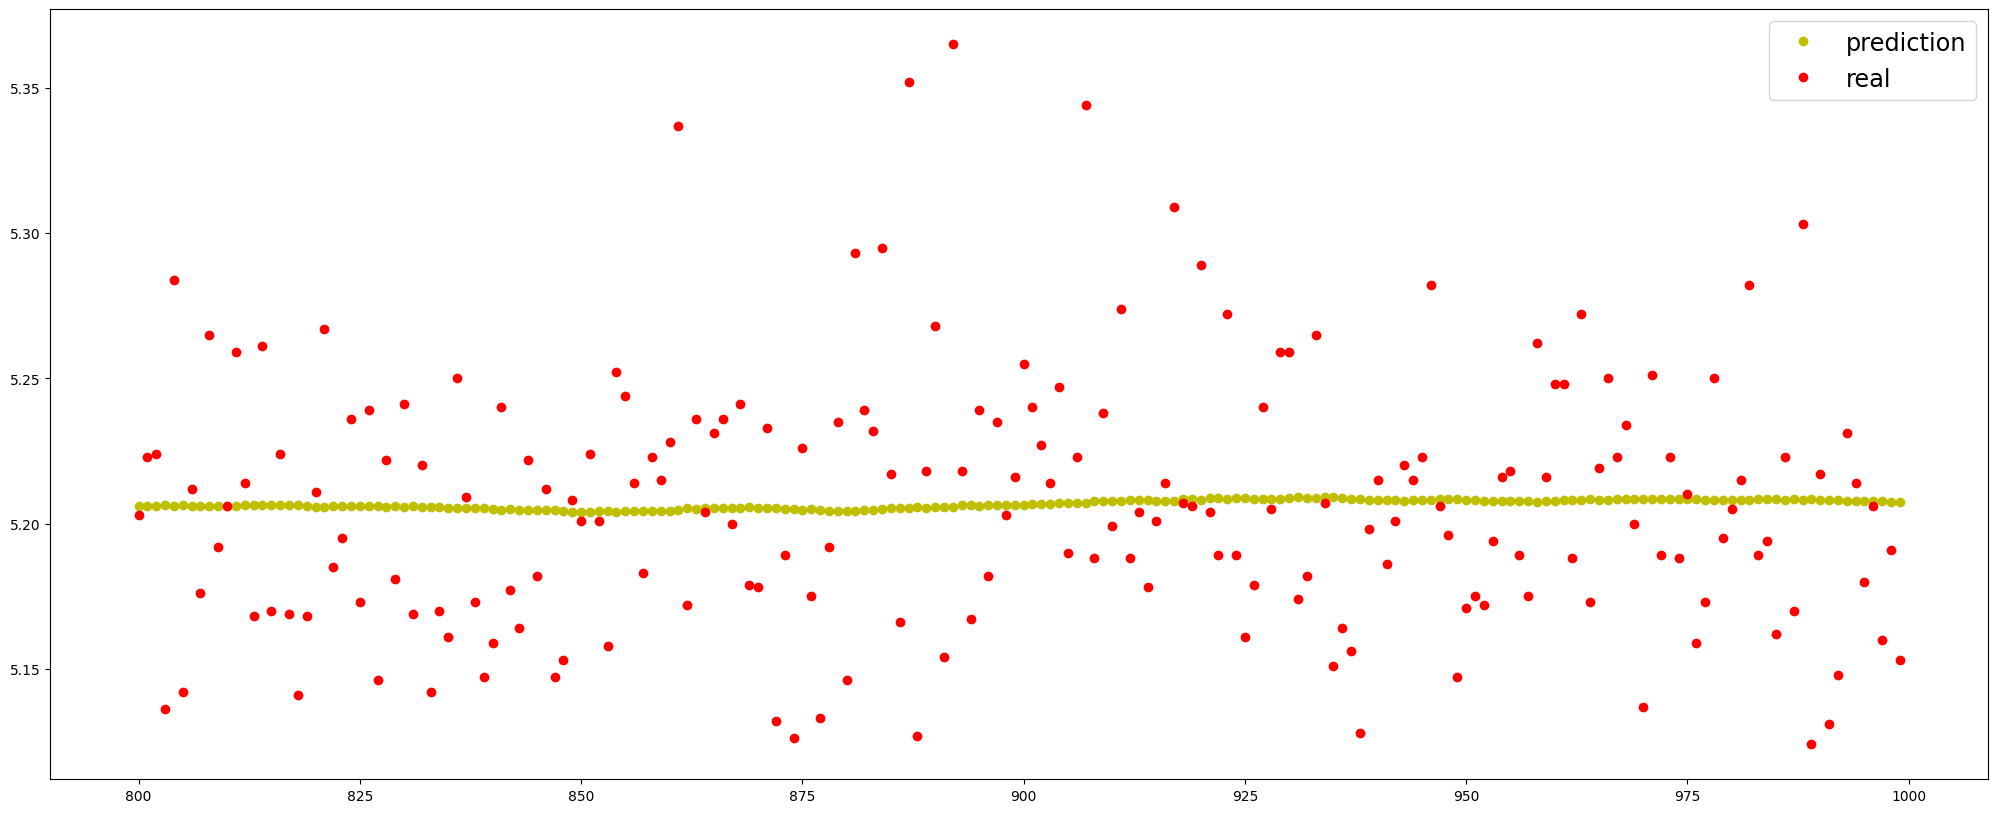

In [90]:
plotDifferencepredictions(pred,test_data)

# holtz winter

In [91]:
from statsmodels.tsa.api import ExponentialSmoothing

In [92]:
model = ExponentialSmoothing(train_data, initialization_method="estimated")
result = model.fit()
pred =  result.predict(start=startTestIndex, end=endtestIndex)

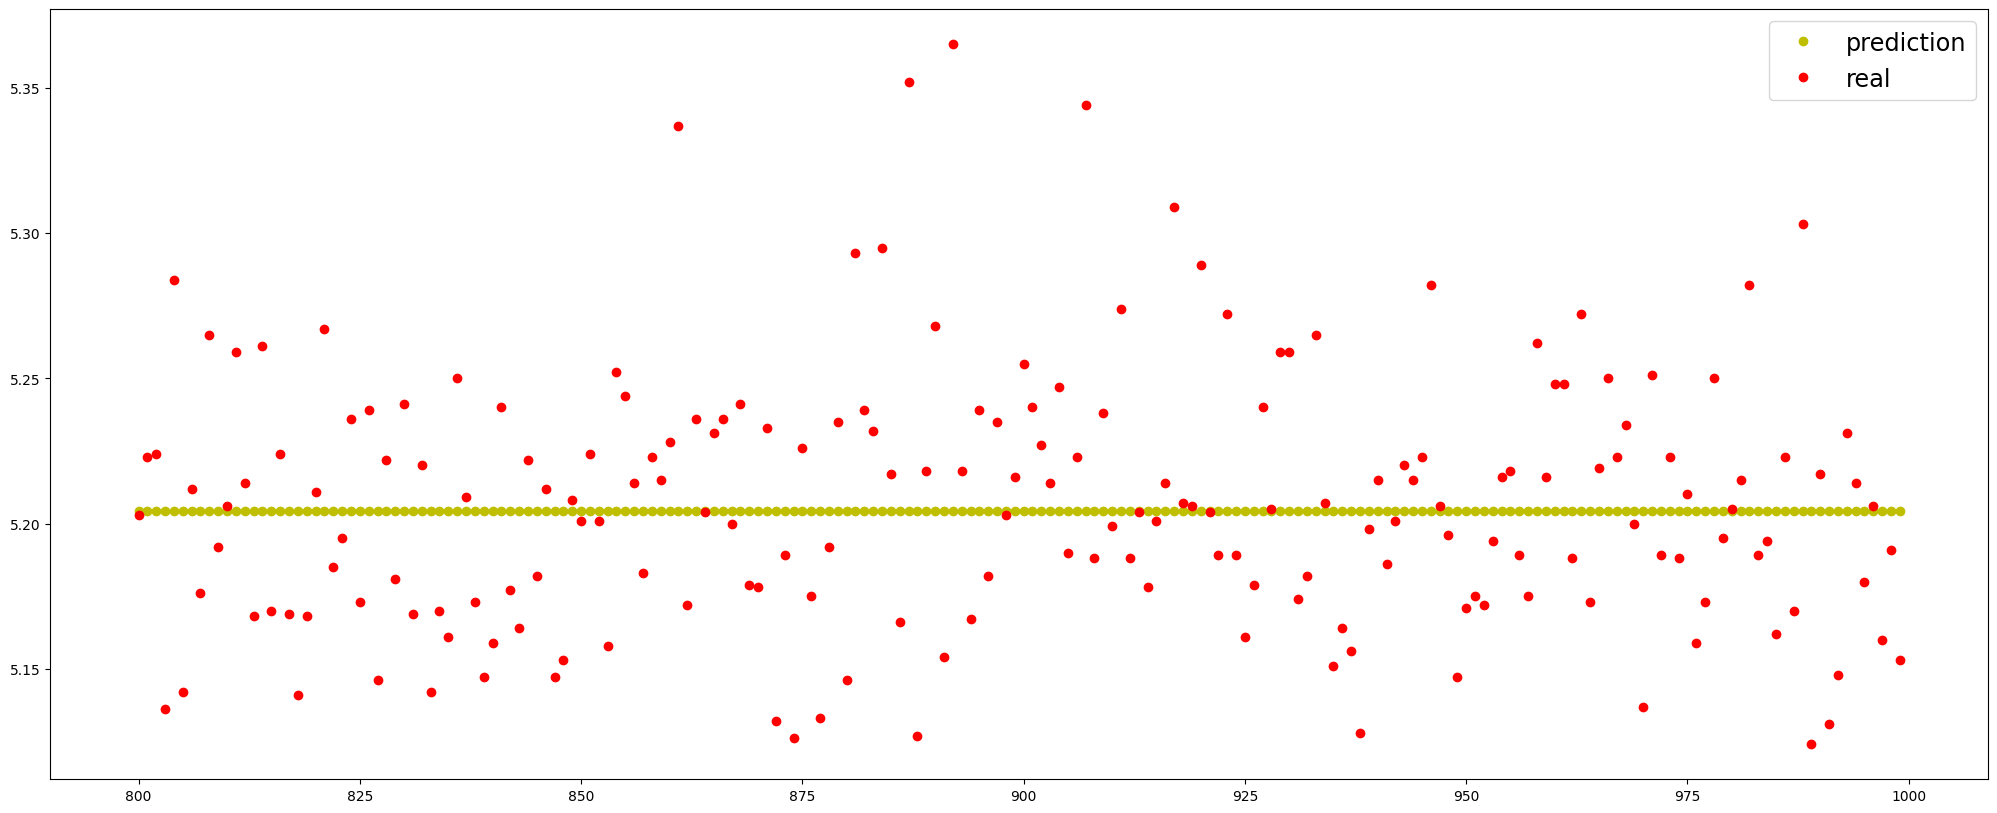

In [93]:
plotDifferencepredictions(pred,test_data)

In [94]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 102 underEstimates with mean 0.008976203648516283 
there are 98 overEstimates with mean 0.023972949678700898
total mean absolute pinball score 0.016324609203306743


(0.008976203648516283, 0.023972949678700898, 0.016324609203306743)

In [95]:
pred = []
for i in range(startTestIndex,len(diff_df)):
    model = ExponentialSmoothing(diff_df["sec"][:i], initialization_method="estimated").fit()
    predict = model.predict(start=i+1, end=(i+1))
    pred.append(predict[i+1])

In [96]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 100 underEstimates with mean 0.00910203841044454 
there are 100 overEstimates with mean 0.023690504318524513
total mean absolute pinball score 0.01639627136448452


(0.00910203841044454, 0.023690504318524513, 0.01639627136448452)

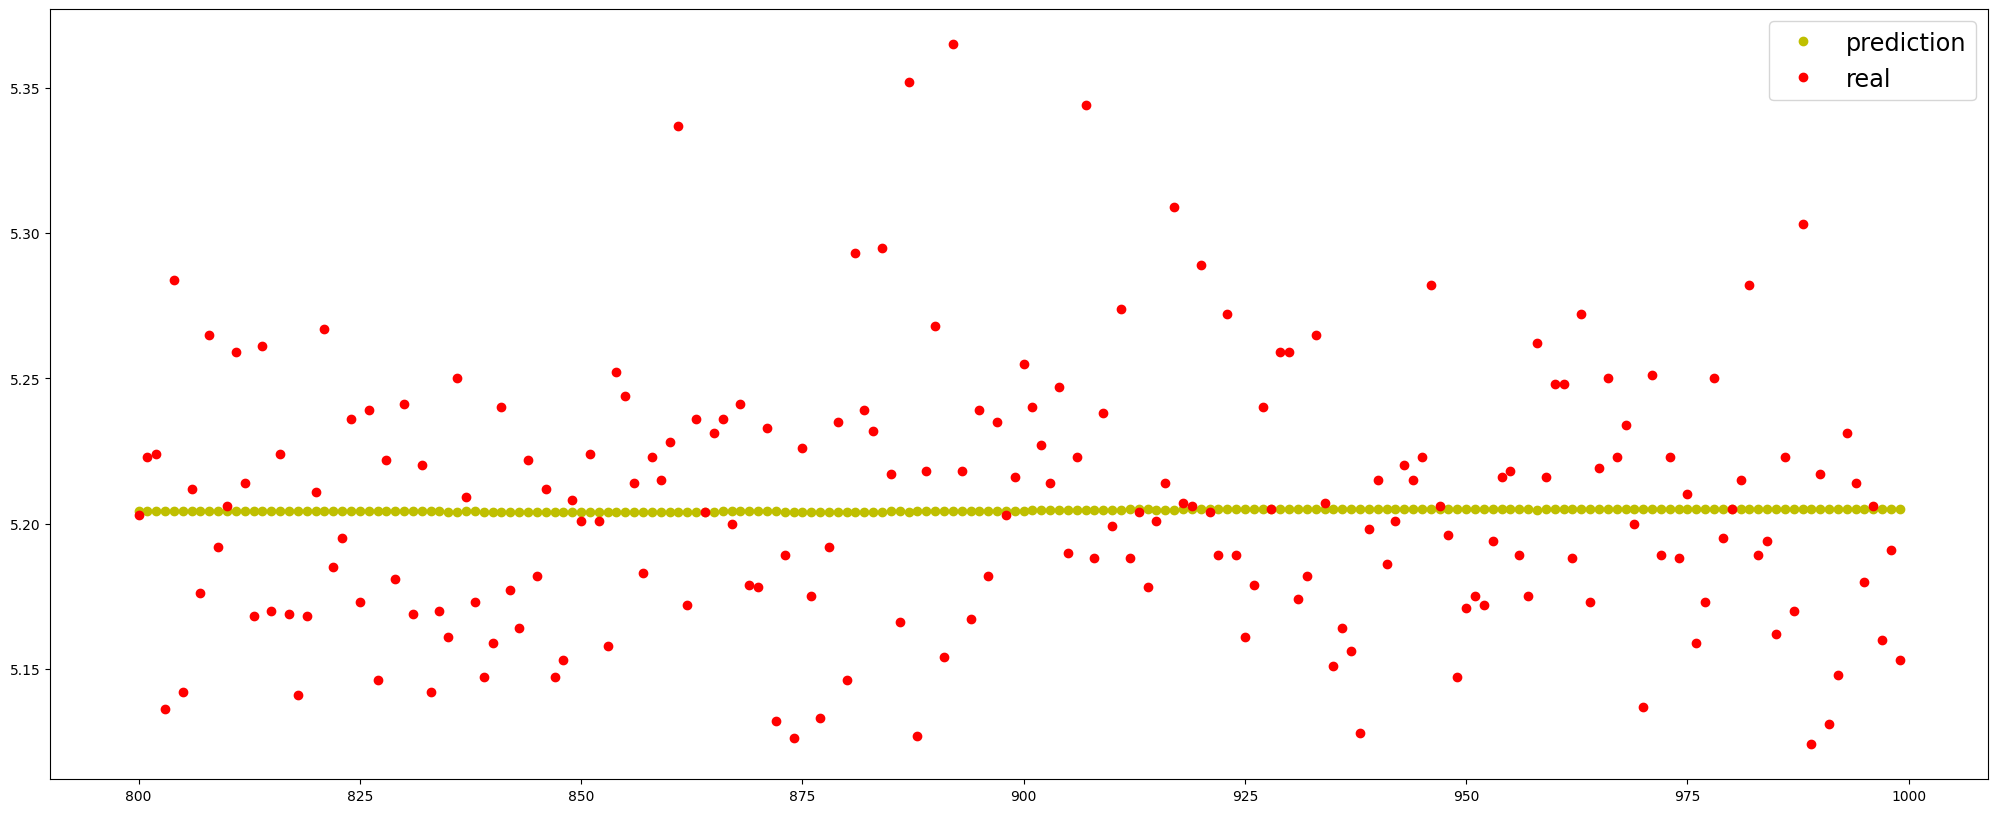

In [97]:
plotDifferencepredictions(pred,test_data)

# LSTM

In [4]:
#https://medium.com/@nutanbhogendrasharma/simple-sequence-prediction-with-lstm-69ff0f4d57cd

def splitSequence(seq, n_steps):
    
    X = []
    y = []

    stopindex = len(seq)-n_steps
    
    for i in range(stopindex):
        #get the last index
        lastIndex = i + n_steps
        
        #Create input and output sequence
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex]
        
        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)     #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)
    
    return X,y 



In [32]:
n_steps  = 20

#  TODO rescale /normalize data ?

X,y = splitSequence(train_data,n_steps)

In [33]:
# reshape from [samples, timesteps] into [samples, timesteps, features]n_features = 1
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X[:2])

[[[3.057]
  [5.   ]
  [5.128]
  [5.127]
  [5.144]
  [5.125]
  [5.125]
  [5.147]
  [5.145]
  [5.143]
  [5.142]
  [5.128]
  [5.129]
  [5.127]
  [5.127]
  [0.206]
  [4.999]
  [5.126]
  [5.127]
  [5.131]]

 [[5.   ]
  [5.128]
  [5.127]
  [5.144]
  [5.125]
  [5.125]
  [5.147]
  [5.145]
  [5.143]
  [5.142]
  [5.128]
  [5.129]
  [5.127]
  [5.127]
  [0.206]
  [4.999]
  [5.126]
  [5.127]
  [5.131]
  [5.126]]]


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [41]:
model = tf.keras.Sequential()
model.add(layers.LSTM(100, activation='tanh', input_shape=(n_steps, n_features)))
model.add(layers.Dense(1))

In [117]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss=tfa.losses.PinballLoss(tau=.25), metrics=['mean_absolute_error'])

In [52]:
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
25/25 [==============================] - 2s 13ms/step - loss: 0.0376 - mean_absolute_error: 0.1106
Epoch 2/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0338 - mean_absolute_error: 0.0964
Epoch 3/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0332 - mean_absolute_error: 0.0949
Epoch 4/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0347 - mean_absolute_error: 0.0983
Epoch 5/200
25/25 [==============================] - 0s 13ms/step - loss: 0.0339 - mean_absolute_error: 0.0988
Epoch 6/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0326 - mean_absolute_error: 0.0934
Epoch 7/200
25/25 [==============================] - 0s 13ms/step - loss: 0.0356 - mean_absolute_error: 0.0992
Epoch 8/200
25/25 [==============================] - 0s 13ms/step - loss: 0.0347 - mean_absolute_error: 0.1002
Epoch 9/200
25/25 [==============================] - 0s 15ms/step - loss: 0.0331 - mean_absolute_error: 0.0948
E

In [53]:
pred = []
for i in range(startTestIndex,len(diff_df)):

    hist = np.array(diff_df["sec"][i-n_steps:i]).reshape((1, n_steps, n_features))
    predict = model.predict(hist, verbose=1)
    pred.append(predict[0][0])

1/1 [==============================] - 0s 24ms/step


In [54]:
total_perside_piball_loss(test_data,pred,alpha=0.25)

there are 161 underEstimates with mean 0.013383339485026298 
there are 39 overEstimates with mean 0.014824199603154141
total mean absolute pinball score 0.013664307208061227


(0.013383339485026298, 0.014824199603154141, 0.013664307208061227)

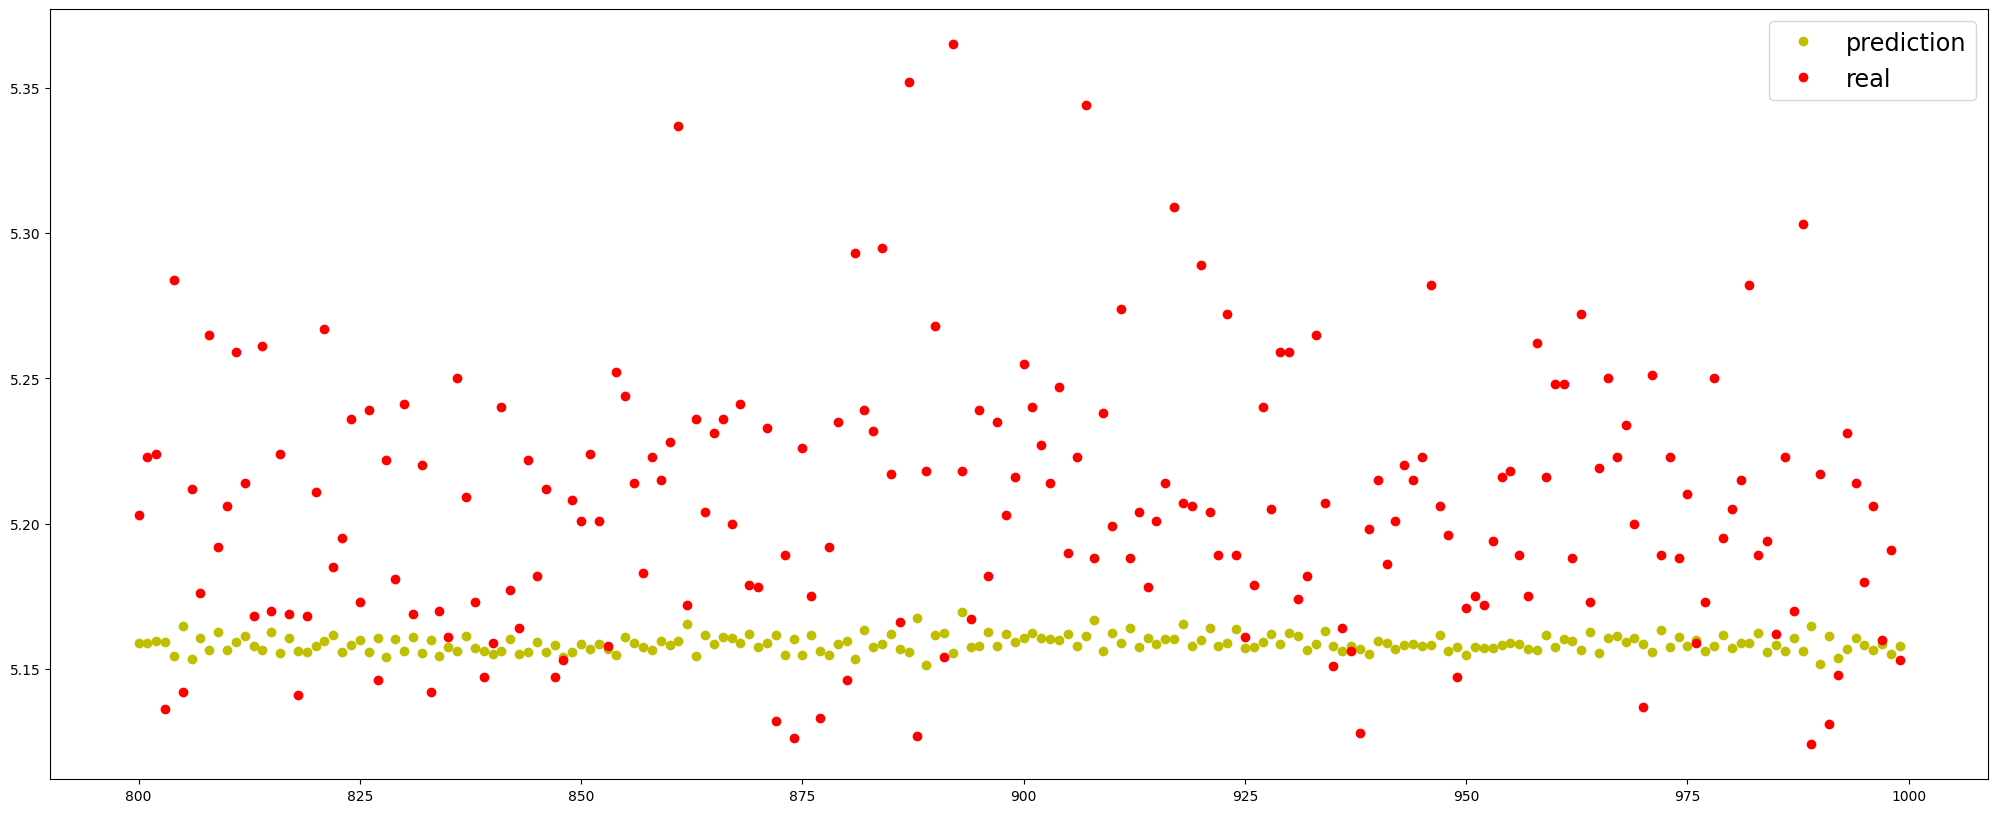

In [46]:
plotDifferencepredictions(pred,test_data)